In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from gptchem.plotsettings import *

%matplotlib inline

## Load results

In [18]:
all_out = glob("out/**/*.pkl")

In [19]:
all_out = [load_pickle(p) for p in all_out]

In [20]:
all_out

[{'train_size': 20,
  'predictions': (#149) [1,1,1,1,0,1,1,0,0,1...],
  'xgboost': {'accuracy': 0.7583892617449665,
   'acc_macro': 0.7583892617449665,
   'racc': 0.7583892617449665,
   'kappa': 0.0,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.4312977099236641,
   'f1_micro': 0.7583892617449665,
   'frac_valid': 1.0,
   'all_y_true': (#149) [1,1,1,1,1,1,1,1,1,1...],
   'all_y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
   'valid_indices': [0,
    1,
    2,
    3,
    4,
    5,
    

In [21]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost"]["accuracy"],
        "f1_macro": out["xgboost"]["f1_macro"],
        "f1_micro": out["xgboost"]["f1_micro"],
        "kappa": out["xgboost"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn"]["accuracy"],
        "f1_macro": out["tabpfn"]["f1_macro"],
        "f1_micro": out["tabpfn"]["f1_micro"],
        "kappa": out["tabpfn"]["kappa"],
    }


    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)


In [22]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [23]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [24]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [25]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [26]:
grouped_res.loc[:]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0    12  0.0  0.732704  0.048010    12  0.013859   
20                1.0  0.0    11  0.0  0.719341  0.057953    11  0.017474   
50                1.0  0.0    11  0.0  0.743316  0.027195    11  0.008199   
100               1.0  0.0     9  0.0  0.777778  0.026127     9  0.008709   
150               1.0  0.0     8  0.0  0.835526  0.099215     8  0.035078   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.429165  0.013560    12  0.003914  0.732704  0.048010    12   
20          0.484162  0.037296    11  0.011245  0.719341  0.057953    11   
50          0.516998  0.057297    11  0.017276  0.743316  0.027195    11   
100         0.632455  0.057007     9  0.019002  0.777778  0.026127     9   
150         0.743894  0.157807     8  0.055793  0.835526  0.099215     8   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.013859 -0.026035  0.054322    12  0.015681  
20          0.017474  0.034137  0.056283    11  0.016970  
50          0.008199  0.090302  0.092203    11  0.027800  
100         0.008709  0.287743  0.097927     9  0.032642  
150         0.035078  0.501270  0.306533     8  0.108376

In [27]:
grouped_tabpfn_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.759958  0.011003    12  0.003176  0.462818  0.036484    12   
20          0.760220  0.026182    11  0.007894  0.550914  0.076140    11   
50          0.773873  0.016576    11  0.004998  0.566732  0.106628    11   
100         0.826087  0.030744     9  0.010248  0.708851  0.084392     9   
150         0.802632  0.061314     8  0.021678  0.688395  0.111860     8   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.010532  0.759958  0.011003    12  0.003176  0.043507  0.055758   
20          0.022957  0.760220  0.026182    11  0.007894  0.157530  0.109029   
50          0.032149  0.773873  0.016576    11  0.004998  0.197113  0.157375   
100         0.028131  0.826087  0.030744     9  0.010248  0.435989  0.148316   
150         0.039548  0.802632  0.061314     8  0.021678  0.397013  0.208300   

                            
           count       sem  
train_size                  
10            12  0.016096  
20            11  0.032874  
50            11  0.047450  
100            9  0.049439  
150            8  0.073645

In [28]:
grouped_xgboost_res

accuracy                                f1_macro                  \
                mean       std count           sem      mean       std count   
train_size                                                                     
10          0.754717  0.000000    12  3.347448e-17  0.430108  0.000000    12   
20          0.742526  0.029142    11  8.786692e-03  0.481739  0.075090    11   
50          0.736440  0.046980    11  1.416489e-02  0.601226  0.067714    11   
100         0.764895  0.043344     9  1.444795e-02  0.651693  0.099185     9   
150         0.796053  0.095143     8  3.363821e-02  0.712821  0.142107     8   

                          f1_micro                                   kappa  \
                     sem      mean       std count           sem      mean   
train_size                                                                   
10          3.347448e-17  0.754717  0.000000    12  3.347448e-17  0.000000   
20          2.264034e-02  0.742526  0.029142    11  8.786692e-03  0.052809   
50          2.041660e-02  0.736440  0.046980    11  1.416489e-02  0.213825   
100         3.306169e-02  0.764895  0.043344     9  1.444795e-02  0.317595   
150         5.024231e-02  0.796053  0.095143     8  3.363821e-02  0.436601   

                                      
                 std count       sem  
train_size                            
10          0.000000    12  0.000000  
20          0.091292    11  0.027526  
50          0.127644    11  0.038486  
100         0.179462     9  0.059821  
150         0.273576     8  0.096724

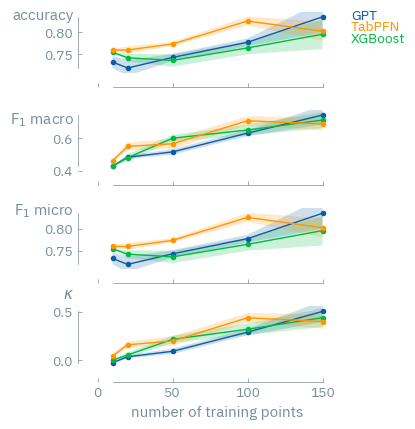

In [29]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[ :].index,
        grouped_res.loc[:][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[ :].index,
        grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
        grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
        grouped_res.loc[ :].index,
        np.stack([
            grouped_res.loc[:][metric]["mean"],
              grouped_xgboost_res.loc[ :][metric]["mean"],
              grouped_tabpfn_res.loc[ :][metric]["mean"], 
        ]).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[ :].index,
        grouped_xgboost_res.loc[ :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[ :].index,
        grouped_xgboost_res.loc[:][metric]["mean"]
        - grouped_xgboost_res.loc[ :][metric]["sem"],
        grouped_xgboost_res.loc[:][metric]["mean"]
        + grouped_xgboost_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[ :].index,
        grouped_tabpfn_res.loc[ :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[ :].index,
        grouped_tabpfn_res.loc[:][metric]["mean"]
        - grouped_tabpfn_res.loc[ :][metric]["sem"],
        grouped_tabpfn_res.loc[ :][metric]["mean"]
        + grouped_tabpfn_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)

fig.savefig("mof_water_stability.pdf", bbox_inches="tight")

In [30]:
find_learning_curve_intersection(
    grouped_res.loc[:]["f1_macro"]["mean"].values[1],
    fit_learning_curve(
        grouped_xgboost_res.loc[:].index,
        grouped_xgboost_res.loc[ :]["f1_macro"]["mean"],
    )[0],
) / grouped_res.loc[:]["f1_macro"]["mean"].index[1]

0.7913250572834969

In [34]:
find_learning_curve_intersection(
    grouped_res.loc[ :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[:].index[:-1],
        grouped_tabpfn_res.loc[:]["f1_macro"]["mean"][:-1],
    )[0],
) / 10

0.934212921990396